In [4]:
'''
2020中国高校计算机大赛·华为云大数据挑战赛
本notebook 是一些简单的model代码，以及EDA，后期要上70+以上，纯考数据分析和线上拟合
'''

'\n2020中国高校计算机大赛·华为云大数据挑战赛\n本notebook 是一些简单的model代码，以及EDA，后期要上70+以上，纯考数据分析和线上拟合\n'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import json
import pandas as pd
from pandas import to_datetime
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from collections import OrderedDict
import datetime
import matplotlib.pyplot as plt
import gc
plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）
# 获取竞赛数据集：将“obs-mybucket-bj4/myfolder”改成您的OBS桶名及文件夹

# read data of one day and one direction
def read_file(path, filename):
    calfile = os.path.join(path, filename)
    original = pd.read_csv(calfile, header=None)
    data = pd.DataFrame(columns=["time", "number"])
    data["time"] = original[0]
    data["number"] = original[3] + original[4]
    return data
    
# read data of one day
def read_data_day(path, date):
    day_data = pd.DataFrame(columns=["time","number"])
    caldir = os.path.join(path, date)
    # read data of one day
    for f in os.listdir(caldir):
        if re.match(r'wuhe_zhangheng.*\.csv', f):
            day_data = day_data.append(read_file(caldir, f), ignore_index=True)
    return day_data

# get and preprocess data
def get_data(path):
    raw_data = pd.DataFrame(columns=["time", "number"])
    for day in os.listdir(path):
        raw_data = raw_data.append(read_data_day(path, day))
    # encode time in raw data to weekday and timeindex(the n minutes of the day)
    df_dt = to_datetime(raw_data.loc[:, "time"], format="%Y/%m/%d %H:%M:%S")
    all_data = pd.DataFrame({
        "weekday": df_dt.dt.weekday/6.0,
        "timeindex": (df_dt.dt.hour * 60 + df_dt.dt.minute)/(24*60.0),
        "number": raw_data["number"].astype(int)})
    print('mean before:',all_data.shape)
    all_data = all_data.groupby(["weekday", "timeindex"]).mean().reset_index(level = ["weekday", "timeindex"])
    all_data.number=all_data.number*4
    return all_data

def train_model(feature,local_data):
    X_train, X_test, y_train, y_test = train_test_split(local_data[feature], local_data['number']*4, test_size=0.1, random_state=42)
    print("X_train shape is: " + str(X_train.shape))
    print("X_test shape is: " + str(X_test.shape))
    
    params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
              'learning_rate': 0.01, 'loss': 'ls'}
    clf = GradientBoostingRegressor(**params)
    clf.fit(X_train, y_train)
#     joblib.dump(clf, LOCAL_MODEL_PATH)

    y_predict = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_predict)
    print("MSE: %.4f" % mse)
    return y_predict
    
def create_config():
    schema_model=json.loads('{"model_algorithm":"gbtree_classification","model_type":"Scikit-learn","runtime":"python3.6","metrics":{},"apis":[{"procotol":"http","url":"/","method":"post","request":{"Content-type":"applicaton/json","data":{"type":"object","properties":{"req_data":{"type":"array","items":[{"type":"string"}]}}}},"response":{"Content-type":"applicaton/json","data":{"type":"object","properties":{"resp_data":{"type":"array","items":[{"type":"number"}]}}}}}]}',object_pairs_hook=OrderedDict)
    schema_model['model_algorithm'] = "gbtree_regression"
    schema_model['model_type'] = "Scikit_Learn"
    with open(LOCAL_CONFIG_PATH, 'w') as f:
        json.dump(schema_model, f)
## 后处理算法
def emitter_data(x):
    x=np.array(x)
    new_x=x.copy()
    for i in range(1,len(x)):
        new_x[i]=(x[i]-x[i-1])*1.3+x[i]
    return new_x    


### 第一步、处理训练数据
### 将trian 数据集中的数据进行整合，把一个路口的数据放在一起并生成timeindex,weeekday等特征
### 当然这里还保留了dt 即时间特征方便之后提取日期，按天进行分割数据

In [397]:
# read data of one day
LOCAL_DATA_PATH='train' #  数据目录.....
days=sorted(os.listdir(LOCAL_DATA_PATH))
print(days)
#  提取这6个路口的数据
for name in ['wuhe_jiaxian','wuhe_zhangheng','wuhe_longping','chongzhi_jiaxian','chongzhi_longping','chongzhi_beier']:
    day_data=pd.DataFrame()
    for day in days:
        # train里面是每天以天日期命名的文件夹
        data_dat_path=os.path.join(LOCAL_DATA_PATH,day) # 这里的天数没有顺序
        for f in os.listdir(data_dat_path):      
            if re.match(r'{}.*\.csv'.format(name), f):#wuhe_jiaxian  wuhe_zhangheng wuhe_longping chongzhi_jiaxian
                original=pd.read_csv(os.path.join(data_dat_path,f), header=None,names=['dt','name','direction','left','straight'])
                if (original.shape[0]<288):
                    print(name+':'+day)

                day_data=day_data.append(original)

    day_data=day_data[['dt','name','direction','left','straight']]
    day_data.dt=to_datetime(day_data.dt, format="%Y/%m/%d %H:%M:%S")
    day_data.sort_values('dt',inplace=True)
    day_data['left']=day_data.left.astype(int)
    day_data['straight']=day_data.straight.astype(int)
    day_data['number']=day_data['left']+day_data['straight']
    day_data['timeindex']=(day_data['dt'].dt.hour * 60 + day_data['dt'].dt.minute)/(24*60.0)
    day_data['weekday']=day_data['dt'].dt.weekday/6.0
    day_data.to_csv(name+'.csv',index=False)

['01-12', '01-13', '01-14', '01-15', '01-16', '01-17', '01-18', '01-19', '01-20', '01-21', '01-22', '01-23', '01-24', '01-25', '01-26', '01-27', '01-28', '01-29', '01-30', '01-31', '02-01', '02-02', '02-03', '02-04', '02-05', '02-06', '02-07', '02-08']
wuhe_jiaxian:01-15
wuhe_jiaxian:01-15
wuhe_jiaxian:01-15
wuhe_zhangheng:01-13
wuhe_zhangheng:01-13
wuhe_zhangheng:01-13
wuhe_zhangheng:01-13
wuhe_zhangheng:01-15
wuhe_zhangheng:01-15
wuhe_zhangheng:01-15
wuhe_zhangheng:01-15
chongzhi_jiaxian:01-14
chongzhi_jiaxian:01-26
chongzhi_jiaxian:01-27
chongzhi_longping:01-14
chongzhi_longping:01-14
chongzhi_longping:01-14
chongzhi_longping:01-14
chongzhi_beier:01-14
chongzhi_beier:01-14
chongzhi_beier:01-14
chongzhi_beier:01-14


 通过上面的信息可以发现，五和张衡这个路口在1月13和1月15号的数据是有缺失的，所以后期模型训练
 时直接舍弃（传统补全数据的方法在这里并不可靠）

### 简单看下不同路口之间的流量关系差距

可以看出靠近路口之间的流量还是比较相近的，后期可以考虑用上其他路口的流量也送入模型

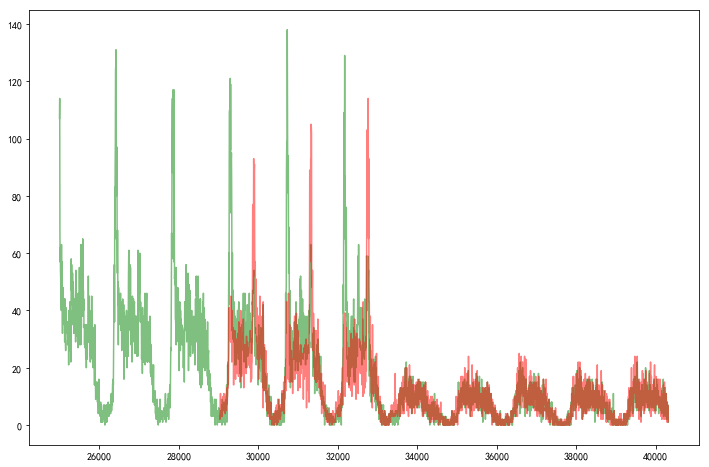

In [273]:
#单独看每个路口的不同发现，这里取五和张衡和五和冲之，因为这两个路口靠的比较近，我们选取同样是south方向的流量进行对比
day_data=pd.read_csv('wuhe_zhangheng.csv')
day_data.dt=to_datetime(day_data.dt)
wz_south=day_data.loc[day_data.direction=='south']
day_data=pd.read_csv('wuhe_longping.csv')
day_data.dt=to_datetime(day_data.dt)
wl_south=day_data.loc[day_data.direction=='south']

wz_south['ax']=(wz_south['dt']-datetime.datetime(2019,1,12))
wz_south['ax']=wz_south['ax'].dt.days*(24*60)+wz_south['ax'].dt.seconds/60

wl_south['ax']=(wl_south['dt']-datetime.datetime(2019,1,12))
wl_south['ax']=wl_south['ax'].dt.days*(24*60)+wl_south['ax'].dt.seconds/60
plt.figure(figsize=(12,8))
plt.plot(wl_south.ax[5000:10000],wl_south.number[5000:10000],color='g',alpha=0.5)
plt.plot(wz_south.ax[5000:10000],wz_south.number[5000:10000],color='r',alpha=0.5)


### 第二步、初步分析数据
### 我们接着分析对比下，不同路口之间的总流量图，并画出所有数据

1、之前也说了 五和张衡有两条的数据是有缺失的，同时可以看到，各个路口的总体趋势还是很一致的。

2、可以看出 相对于靠近春节的流量是呈现下降趋势的，而春节期间的流量明显比平时要小很多，并且没有明显的
早高峰。

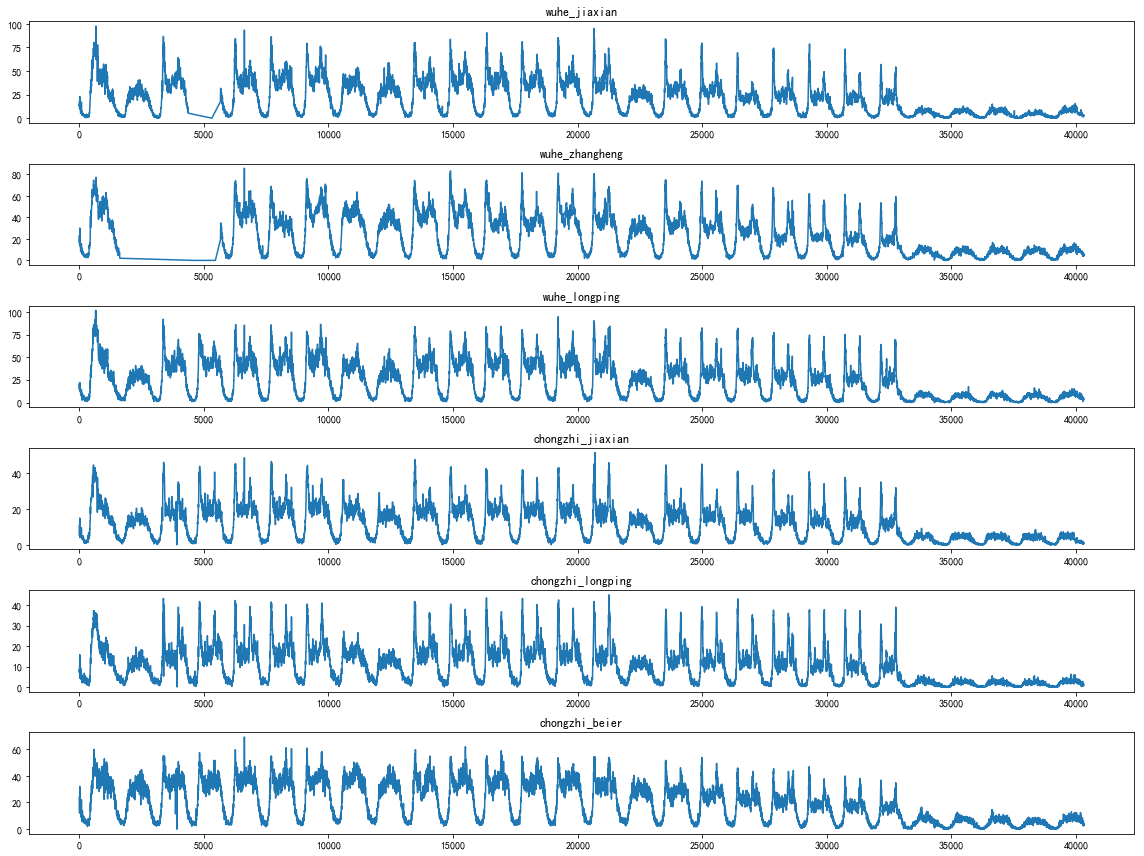

In [219]:
## 画出全局
fig,ax=plt.subplots(figsize=(16,12),nrows=6,ncols=1)
count=0
for name in ['wuhe_jiaxian','wuhe_zhangheng','wuhe_longping','chongzhi_jiaxian','chongzhi_longping','chongzhi_beier']:
    day_data=pd.read_csv(name+'.csv')
    day_data.dt=to_datetime(day_data.dt)
    day_data['ax']=(day_data['dt']-datetime.datetime(2019,1,12))
    day_data['ax']=day_data['ax'].dt.days*(24*60)+day_data['ax'].dt.seconds/60
    tmp=day_data.groupby('ax').mean().reset_index()
    ax[count].plot(tmp['ax'],tmp['number'])
    ax[count].set_title(name)
    count+=1
plt.tight_layout()

接下来选取了冲之嫁先路口的数据进行分析

对数据以周为单位区分，将一周的数据画在一张subplot上，观察一周内每天的流量变化，总共四周

In [ ]:
dat_data=pd.read_csv('chongzhi_jiaxian.csv') # 读取数据
##------------分成四周
first_week=day_data.loc[(day_data['dt']>=datetime.datetime(2019,1,14))&(day_data['dt']<=datetime.datetime(2019,1,20))]
second_week=day_data.loc[(day_data['dt']>=datetime.datetime(2019,1,21))&(day_data['dt']<=datetime.datetime(2019,1,27))]
thress_week=day_data.loc[(day_data['dt']>=datetime.datetime(2019,1,28))&(day_data['dt']<=datetime.datetime(2019,2,3))]
last_week=day_data.loc[(day_data['dt']>=datetime.datetime(2019,2,4))&(day_data['dt']<=datetime.datetime(2019,2,8))]
first_week=first_week.groupby(['timeindex','weekday']).mean().reset_index(level = ["weekday", "timeindex"])
second_week=second_week.groupby(['timeindex','weekday']).mean().reset_index(level = ["weekday", "timeindex"])
thress_week=thress_week.groupby(['timeindex','weekday']).mean().reset_index(level = ["weekday", "timeindex"])
last_week=last_week.groupby(['timeindex','weekday']).mean().reset_index(level = ["weekday", "timeindex"])
## 2019,1,14号的数据没有，15号的数据异常 可能是施工, 2-4 ~2-8是春节一周 
# 预测2-11 和2-14 周一（2019年2月11日）和周四（2019年2月14日）两天的

Text(0.5, 0.98, '冲之嫁先路口')

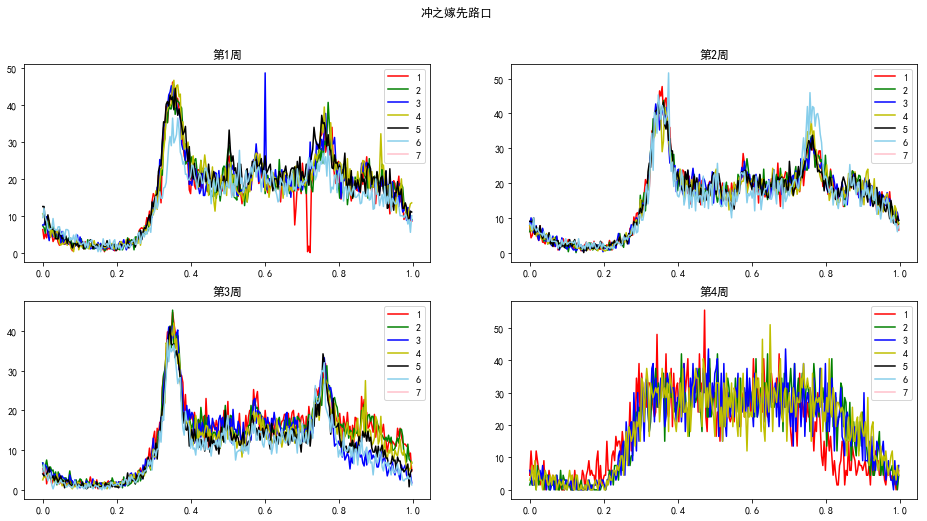

In [879]:
df_list=[first_week,second_week,thress_week,last_week]
fig,ax=plt.subplots(figsize=(16,8),nrows=2,ncols=2)
color=['r','g','b','y','black','skyblue','pink']
count=0
for k in range(2):
    for t in range(2):
        for i in range(0,7):
            x=df_list[count][df_list[count].weekday==i/6]['timeindex']
            y=df_list[count][df_list[count].weekday==i/6]['number']
            if count==3:
                y=y*6
            ax[k][t].plot(x,y, color=color[i], label=i+1)
            ax[k][t].legend()
            ax[k][t].set_title('第{}周'.format(count+1)) 
        count+=1
fig.suptitle('冲之嫁先路口')


### 第三步、准备数据

In [ ]:
##-------- 生成训练集
predict_df= pd.DataFrame(columns = ["weekday", "timeindex",'dt'])
days=['2019-2-11','2019-2-14']
test_df=pd.DataFrame()
for day in days:
    timestamp= to_datetime(day, format="%Y-%m-%d")
    dt=[timestamp+datetime.timedelta(minutes=i) for i in range(300, 1256, 5)]*4
    direct=['east']*(len(dt)//4)+['north']*(len(dt)//4)+['south']*(len(dt)//4)+['west']*(len(dt)//4)
    df1=pd.DataFrame({'dt':dt,'direction':direct})
    df1['timeindex']=((df1['dt'].dt.hour * 60.0 + df1['dt'].dt.minute)/(24*60.0)).astype('float64')
    df1['weekday']=df1['dt'].dt.weekday/6.0
    test_df=test_df.append(df1,ignore_index=True)
test_df['isTest']=1
test_df['name']='wuhe_zhangheng'

In [163]:
## 将预测数据与我们的训练数据合并起来
day_data=pd.read_csv('wuhe_zhangheng.csv')
day_data=day_data.append(test_df,ignore_index=True)

day_data.dt=to_datetime(day_data.dt)
# 单天标签，这个可以作为特征，同时也是为了以天为单位加以区分数据
day_data['day_tag']=day_data['dt'].dt.month*100+day_data['dt'].dt.day

d:\python3.5\lib\site-packages\pandas\core\frame.py:6701: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [164]:
# ###-----------------------------------------
# z五和张衡的13 15数据有问题 有缺失
print(day_data.shape)
# day_data=day_data[~((day_data['day_tag']>=204)&(day_data['day_tag']<=210))]
day_data=day_data[~(day_data['day_tag']==115)]
day_data=day_data[~(day_data['day_tag']==113)]
print(day_data.shape)

day_data['holiday']=0
day_data.loc[day_data['day_tag']==117,'holiday']=1
day_data.loc[(day_data['day_tag']>=204)&(day_data['day_tag']<=210),'holiday']=-1
# day_data.loc[day_data['day_tag']==211,'holiday']=1
day_data.loc[day_data['day_tag']==214,'holiday']=2

'''***注意 我们题目是预测路口总流量，所以要对四个方向的流量做一个聚合,这里是取均值，所以最后预测的时候Number总流量要乘4'''   
day_data=day_data.groupby(['day_tag','timeindex']).mean().reset_index()

(30572, 10)
(30336, 10)


##### 我们以周为单位拆分数据，一边是为了分析，另外是为了组合出训练集，为的是做数据增强
##### 我们思路是可以以周为单位聚合我们的数据，送入训练集，来构建更贴近 线上那两天的数据。

(864, 19)


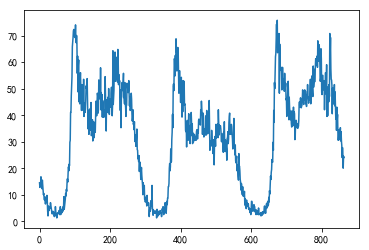

In [171]:
##  第一周，这里只取了周一到周五（工作日），因为线上的数据是周一和周四 也是正常的工作日
##  注意 第一周 是少了两天的数据的，只从1月14号开始
first_week=day_data.loc[(day_data['day_tag']>=114)&(day_data['day_tag']<=118)]
first_week=first_week.groupby(['day_tag','weekday','timeindex']).mean().reset_index(level=['day_tag','weekday','timeindex'])
first_week.sort_values(['day_tag','weekday','timeindex'],inplace=True)
first_week.reset_index(drop=True,inplace=True)

# first_week.iloc[173,6]=first_week.iloc[172:175].number.values.mean()
plt.plot(first_week.number)
print(first_week.shape)


(1440, 19)


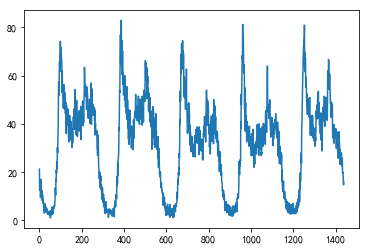

In [170]:
second_week=day_data.loc[(day_data['day_tag']>=121)&(day_data['day_tag']<=125)]
second_week=second_week.groupby(['day_tag','weekday','timeindex']).mean().reset_index(level=['day_tag','weekday','timeindex'])
second_week.sort_values(['day_tag','weekday','timeindex'],inplace=True)
second_week.reset_index(drop=True,inplace=True)
plt.plot(second_week.number)
print(second_week.shape)


(2016, 19)


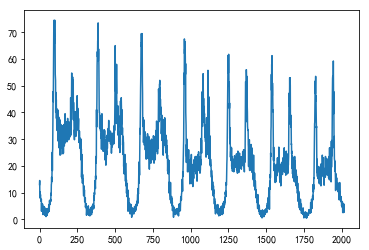

In [169]:
three_week=day_data.loc[(day_data['day_tag']>=128)&(day_data['day_tag']<=203)]
three_week=three_week.groupby(['day_tag','weekday','timeindex']).mean().reset_index(level=['day_tag','weekday','timeindex'])
three_week.sort_values(['day_tag','weekday','timeindex'],inplace=True)
three_week.reset_index(drop=True,inplace=True)
plt.plot(three_week.number)
print(three_week.shape)

(1440, 19)


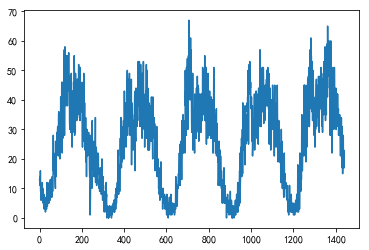

In [168]:

last_week=day_data.loc[(day_data['day_tag']>=204)&(day_data['day_tag']<=210)]
last_week=last_week.groupby(['day_tag','weekday','timeindex']).mean().reset_index(level=['day_tag','weekday','timeindex'])
last_week.sort_values(['day_tag','weekday','timeindex'],inplace=True)
last_week.reset_index(drop=True,inplace=True)
# last_week.number=last_week.number.values*0.8+three_week.number.values*0.8
plt.plot(last_week.number*4)
print(last_week.shape)

接下来我们尝试做了一些特征：

1、上一周同方向上的流量

2、上一周同时段的增长率

3、天气特征（从网上爬取的）

4、节假日标记

5、距离春节的时间间隔（day为单位）

In [165]:
# 得到上一周同时段同方向的流量
day_data['last_number']=day_data.groupby(['timeindex','weekday','direction'])['number'].shift(1)
day_data['last_left']=day_data.groupby(['timeindex','weekday','direction'])['left'].shift(1)
day_data['last_straight']=day_data.groupby(['timeindex','weekday','direction'])['straight'].shift(1)
# 计算上一周同时段的增长率
day_data['diff_last_number']=day_data['last_number']-day_data.groupby('day_tag')['last_number'].shift(1)
day_data['diff_last_left']=day_data['last_left']-day_data.groupby('day_tag')['last_left'].shift(1)
day_data['diff_last_straight']=day_data['last_straight']-day_data.groupby('day_tag')['last_straight'].shift(1)
###-----------------
# 添加天气
weather=pd.read_csv('processed_shenzhen_weather.csv')
weather.date=to_datetime(weather.date)
weather['day_tag']=weather['date'].dt.month*100+weather['date'].dt.day
weather.drop('date',axis=1,inplace=True)
day_data=day_data.merge(weather,on='day_tag',how='left')
# encoding方向
day_data.direction=day_data['direction'].map({'east':1, 'north':2, 'south':3, 'west':4})
# 添加距离2-7 好的天数间隔的绝对值
day_data.loc[day_data.day_tag<=203,'holiday_gap']=abs((day_data.loc[day_data.day_tag<=203,'dt']-datetime.datetime(2019,2,3)).dt.days)
day_data.loc[day_data.day_tag>=210,'holiday_gap']=abs((day_data.loc[day_data.day_tag>=210,'dt']-datetime.datetime(2019,2,10)).dt.days)
# 1-18 年会，2-4 2-5 除夕 春节

### 第四步、模型训练

通过以上一些数据的处理分析，我们构建了一些特征并处理了数据

但是很遗憾，在实际模型训练中，发现这些特征并不能很好的work，甚至会导致模型不能准确的预测

从数据分析和实际场景中也能感受到，我们无法很好的捕捉到年后的流量预测，因为我们并没有以往相应时段的流量数据作为依据

In [ ]:
'''我们这里举个了个模型预测的基础例子，特征也只选了基础的特征
   同时结合之前的数据分析和说明，只要训练集和验证集构建的好，是可以达到65以上的分数的
   数据集的构建还是我之前说的，以天或周为单位，组成训练集，增强数据就是取几天的或者几周（其他路口的也可以）做平均，作为新增的数据。'''
feature=['timeindex','weekday','day_tag']
pred=train_model(feature,local_data=day_data)

In [239]:
###---------尝试用lgb建模-----------
train_data=day_data.loc[((day_data['day_tag']!=128)&(day_data['day_tag']<=203)&(day_data['day_tag']!=131))&(day_data.isTest!=1)]
train_data=train_data.groupby(["weekday", "timeindex",'day_tag']).mean().reset_index(level = ["weekday", "timeindex",'day_tag'])
train_data.sort_values(['day_tag','weekday','timeindex'],inplace=True)
train_data.reset_index(drop=True,inplace=True)
print('train data:',train_data.shape)
val_data=day_data.loc[(day_data['day_tag']==128)|(day_data['day_tag']==131)]
val_data=val_data.groupby(["weekday", "timeindex",'day_tag']).mean().reset_index(level = ["weekday", "timeindex",'day_tag'])
val_data.sort_values(['day_tag','weekday','timeindex'],inplace=True)
val_data.reset_index(drop=True,inplace=True)
print('val data:',val_data.shape)
gc.collect()
test_data=day_data.loc[day_data.isTest==1]
test_data=test_data.groupby(["weekday", "timeindex",'day_tag']).mean().reset_index(level = ["weekday", "timeindex",'day_tag'])
test_data.sort_values(['day_tag','weekday','timeindex'],inplace=True)
test_data.reset_index(drop=True,inplace=True)
print(test_data.shape)

from lightgbm.sklearn import LGBMRegressor
feature=['day_tag', 'timeindex','weekday']
clf=LGBMRegressor(num_leaves=516,n_estimators=10000,random_state=1211,reg_lambda=0.02,learning_rate=0.01,metric=['mse'])
clf.fit(train_data[feature],train_data.number*4,eval_set=[(val_data[feature],val_data.number)],verbose=500,eval_metric=['mse'])
pred=clf.predict(val_data[feature])


[500]	valid_0's l2: 1891.34
[1000]	valid_0's l2: 1874.97
[1500]	valid_0's l2: 1873.92
[2000]	valid_0's l2: 1873.77
[2500]	valid_0's l2: 1871.28
[3000]	valid_0's l2: 1865.54
[3500]	valid_0's l2: 1865.08
[4000]	valid_0's l2: 1873.99
[4500]	valid_0's l2: 1881.15
[5000]	valid_0's l2: 1876.8
[5500]	valid_0's l2: 1876.89
[6000]	valid_0's l2: 1878.82
[6500]	valid_0's l2: 1878.49
[7000]	valid_0's l2: 1874.97
[7500]	valid_0's l2: 1870.54
[8000]	valid_0's l2: 1865.87
[8500]	valid_0's l2: 1862
[9000]	valid_0's l2: 1858.11
[9500]	valid_0's l2: 1856.75
[10000]	valid_0's l2: 1856.25


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.01, max_depth=-1,
       metric=['mse'], min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=516,
       objective=None, random_state=1211, reg_alpha=0.0, reg_lambda=0.02,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

## 第五步、线上数据分析


In [ ]:
'''通过以上处理步骤，分数是可以达到68、69 的成绩的，但是想进一步突破却比较难，
    毕竟数据有限，我们能得到的信息很少。
    但是我们发现，只要训练数据构建的好，分数就会有明显的提升，那么怎么才算好呢，其实就是越靠近
    线上数据作为训练数据，效果就越好，因为回归模型的本质其实就是拟合数据。
    那这样我们是不是可以人为构造线上数据，而不 是用模型预测呢（因为模型会有误差）
    通过实验是肯定的，我们这里还得到了，另外一个赛题的数据，也是流量相关的，但是他们的题目是预测交通指数，些许不一样
    这里简单画了下图：
'''

“华为云杯”2020深圳开放数据应用创新大赛 ·深圳北站周边交通拥堵指数预测
:https://competition.huaweicloud.com/information/1000040088/introduction

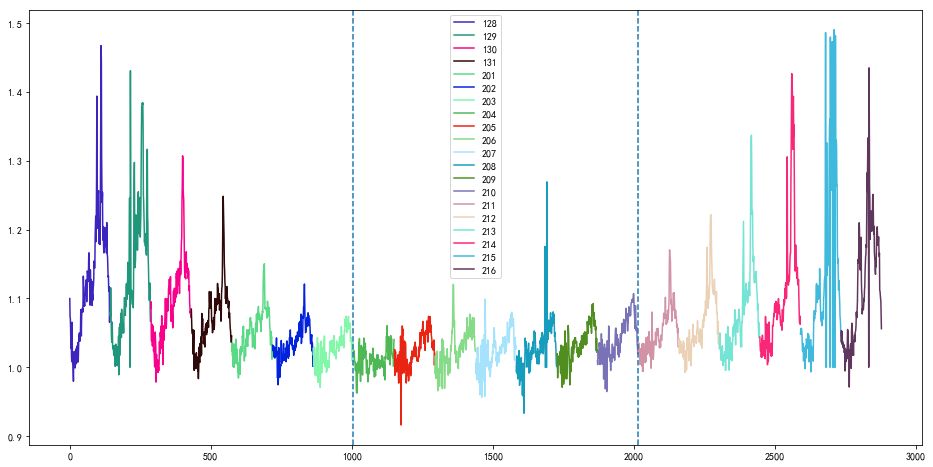

In [227]:
tti=pd.read_csv('train_TTI.csv')
tti.time=to_datetime(tti.time)
part_tti=tti.loc[(tti.time>datetime.datetime(2019,1,28))&(tti.time<datetime.datetime(2019,2,17))]
del tti
part_tti.reset_index(drop=True,inplace=True)
part_tti=part_tti.loc[(part_tti.id_road==276183)]
part_tti['day_tag']=part_tti.time.dt.month*100+part_tti.time.dt.day
part_tti.loc[part_tti.TTI>1.5,'TTI']=1
plt.figure(figsize=(16,8))
days=part_tti.day_tag.unique()
for d in days:
    plt.plot(part_tti.loc[(part_tti.day_tag==d)].TTI,color=np.random.rand(3),label=str(d))

plt.axvline(part_tti.loc[part_tti.day_tag==203].index.max(),linestyle='--')
plt.axvline(part_tti.loc[part_tti.day_tag==210].index.max(),linestyle='--')
plt.legend()

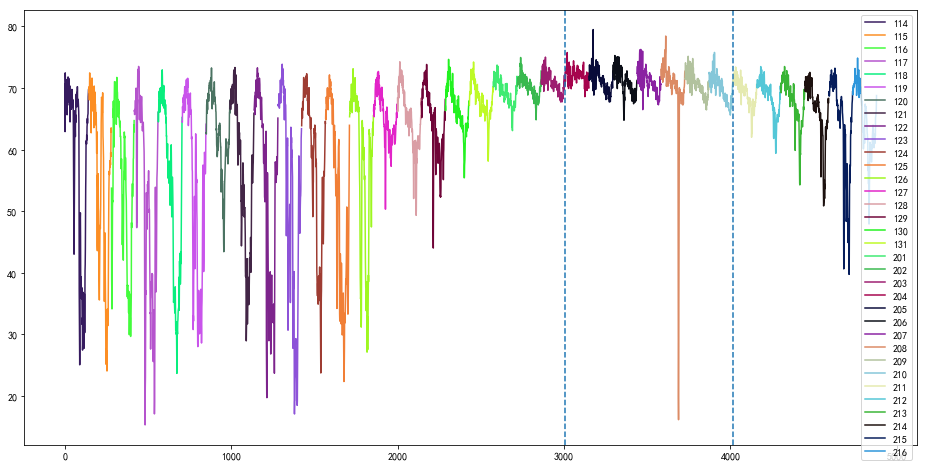

In [208]:
plt.figure(figsize=(16,8))
days=part_tti.day_tag.unique()
for d in days:
    plt.plot(part_tti.loc[(part_tti.day_tag==d)].speed,color=np.random.rand(3),label=str(d))

plt.axvline(part_tti.loc[part_tti.day_tag==203].index.max(),linestyle='--')
plt.axvline(part_tti.loc[part_tti.day_tag==210].index.max(),linestyle='--')
plt.legend()

##### 上图可以看出，春节前后的流量其实是呈现对称性的，我们可以猜测年后的流量也是由小变大的，和年前数据成轴对称趋势
##### 比如 2月3号（春节前一天） 可能对应就是2月11号的流量

有了这样的依据，我们通过组合不同天数的数据以及启发式方法多次加权融合，最后达到了线上76+的成绩，一度获得榜上第一的成绩

#### 提交结果终版：

In [175]:
### 需要用到的数据切分和处理-----------------
mm1=three_week[(three_week.timeindex>=0.20832)&(three_week.timeindex<0.8716)]
mm1=mm1.groupby(['timeindex']).mean().reset_index(level=['timeindex'])
mm1=mm1.number.values*4

combbin=three_week[(three_week.timeindex>=0.20832)&(three_week.timeindex<0.8716)&(three_week.weekday==5/6)].number.values
new_mm1=(mm1*2.1+combbin*4)/3

three_mean=three_week[(three_week.weekday==2/6)&(three_week.timeindex>=0.20832)&(three_week.timeindex<0.8716)].number.values
combine=(three_mean*8+np.array(second_mean[half:]))/3

## 对分段出来的数据进行融合----------

test_mean=[i for index,i in enumerate(mm1)]+[1.1*i for i in combine] # 初期版本74+

# 中期版本
new_test_mean=[i for index,i in enumerate(mm1)]+[i if (index>=32 and index <=46) else i*1.1 for index,i in enumerate(combine)] 75+

# 后期版本（做了一个类似平滑的操作）
## 定义一个平滑函数
def data_smoother(df, features, alpha=20, beta=1):
    tmp = df.groupby(['serial_number', 'model'])
    for feature in features:
        df[feature + "_smooth"] = tmp[feature].shift(0) - (
                    tmp[feature].shift(1) * (alpha - beta) / alpha + tmp[feature].shift(0) * beta / alpha)
    return df
def smoth(a_list,l,r, alpha=20, beta=8):
    for i in range(l+1,r):
        a_list[i]=a_list[i]+((a_list[i+1]-a_list[i])*(alpha - beta)/alpha+  beta / alpha)
    return a_list

new_test_mean1=smoth(new_test_mean.copy(),250,335)
new_test_mean1=smoth(new_test_mean1,60,140) #线上76+

####  到此，基本上以及结束了，以上差不多是我们在热身赛的一些处理和尝试
#### 当然里面也有很多其他尝试，但是并没有很work 所以就没有提及
####  随后要在线上拿到不错的成绩就是不断地取试数据，通过每天的流量趋势来猜测年后的数据分布，通过画图来对比前后差异
#### 下面就是我在实验过程中 不断精分的分析图

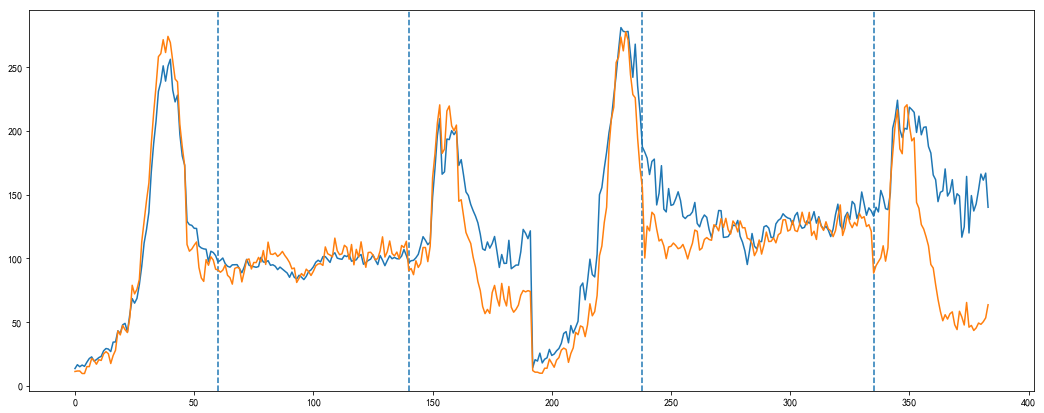

In [285]:
plt.figure(figsize=(18,7))
# plt.xlim(0,256)
# plt.plot(result_data)
plt.axvline(238,linestyle='--')
plt.axvline(335,linestyle='--')
plt.axvline(60,linestyle='--')
plt.axvline(140,linestyle='--')
# plt.axvline(193,linestyle='--')
# plt.axvline(218,linestyle='--')
# plt.axvline(370,linestyle='--')
# plt.axvline(378,linestyle='--')

# plt.plot(test_df.number)
# plt.plot(new_mean)
# 
# plt.plot(result_data)
# plt.plot(test_mean)
# plt.plot(train_data.number*4)
plt.plot(np.round(new_test_mean))

plt.plot(new_test_mean1)
# plt.plot(fix_new_test_mean1)
# plt.plot(pred_fix)

### 我们还对预测结果 ，进行了perman相关分析，来看哪些天的数据和线上数据比较相关

Text(0.5, 1.0, '2月14')

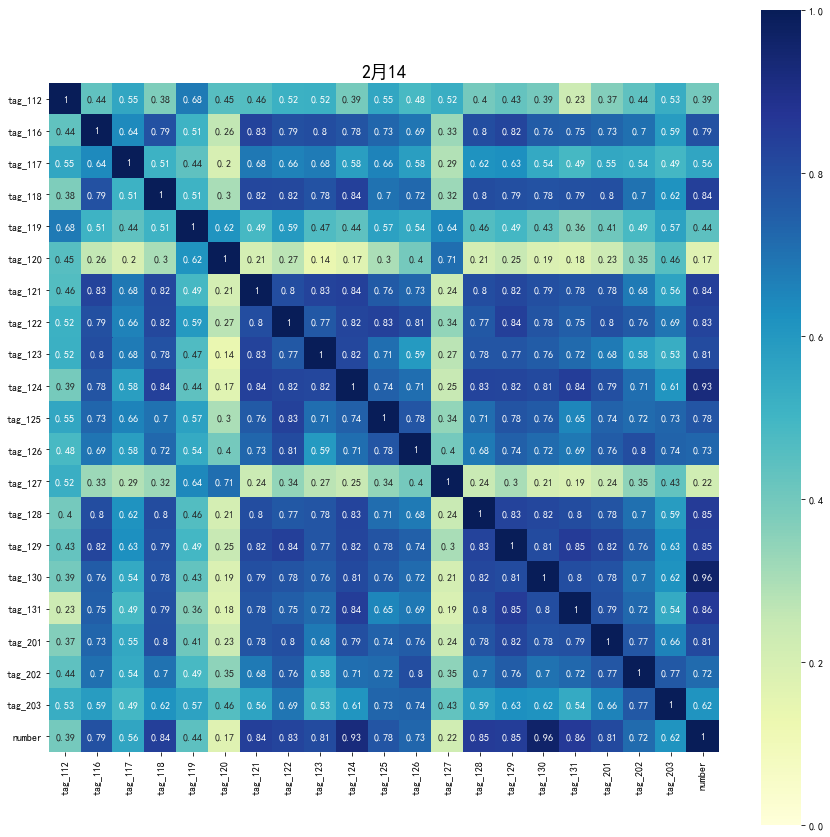

In [52]:
import seaborn as sns
import numpy as np
import pandas as pd
fig, ax = plt.subplots(figsize = (15,15))
#二维的数组的热力图，横轴和数轴的ticklabels要加上去的话，既可以通过将array转换成有column
#和index的DataFrame直接绘图生成，也可以后续再加上去。后面加上去的话，更灵活，包括可设置labels大小方向等。
sns.heatmap(corr, cmap="YlGnBu",annot=True, vmax=1,vmin = 0, xticklabels= True, yticklabels= True, square=True)
#sns.heatmap(np.round(a,2), annot=True, vmax=1,vmin = 0, xticklabels= True, yticklabels= True, 
#            square=True, cmap="YlGnBu")
ax.set_title('2月14', fontsize = 18)
# ax.set_ylabel('数字', fontsize = 18)
# ax.set_xlabel('字母', fontsize = 18) #横变成y轴，跟矩阵原始的布局情况是一样的


### ------------------------------ 分割线----------（下面是实验草稿）---------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------------------------

In [10]:
test_df=test_df.groupby(['weekday','timeindex']).mean().reset_index()
for tag in day_data.day_tag.unique()[:-2]:
    test_df['tag_'+str(tag)]=day_data.loc[(day_data.day_tag==tag)&(day_data.timeindex>=0.20832)&(day_data.timeindex<0.8716)].number.to_list()*2

In [21]:
test_df['number']=test_mean
# test_df['number']=test_df.predict

In [22]:
test_df['diff_last_number']=test_df.groupby('weekday')['number'].shift(0)-test_df.groupby('weekday')['number'].shift(1)
for col in day_data.day_tag.unique()[:-2]:
    test_df['diff'+str(col)]=test_df['tag_'+str(col)]-test_df.groupby('weekday')['tag_'+str(col)].shift(1)

In [49]:
corr=test_df.loc[test_df.weekday==0.5,[ 'tag_112', 'tag_116', 'tag_117',
       'tag_118', 'tag_119', 'tag_120', 'tag_121', 'tag_122', 'tag_123',
       'tag_124', 'tag_125', 'tag_126', 'tag_127', 'tag_128', 'tag_129',
       'tag_130', 'tag_131', 'tag_201', 'tag_202', 'tag_203', 'number']].corr('spearman')

In [50]:
corr['number']

tag_112    0.394999
tag_116    0.785678
tag_117    0.557517
tag_118    0.842639
tag_119    0.444711
tag_120    0.174114
tag_121    0.842593
tag_122    0.827026
tag_123    0.806805
tag_124    0.925620
tag_125    0.776205
tag_126    0.729357
tag_127    0.222408
tag_128    0.854082
tag_129    0.847489
tag_130    0.964470
tag_131    0.855876
tag_201    0.812259
tag_202    0.717699
tag_203    0.616564
number     1.000000
Name: number, dtype: float64

ValueError: x and y must have same first dimension, but have shapes (2016,) and (1440,)

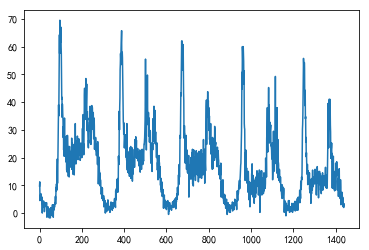

In [13]:
resid3=three_week.number-last_week.number
plt.plot(range(len(resid3)),resid3)
resid2=second_week.number-last_week.number
plt.plot(range(len(resid3)),resid2)
plt.plot(resid1)

In [ ]:
import statsmodels.api as sm
mean_trend=day_data.loc[(day_data.day_tag>=118)&(day_data.day_tag<=203)][['weekday','timeindex','direction','number']]
rd=sm.tsa.seasonal_decompose(mean_trend.number.values,period=12)
mean_trend['trend_number']=rd.trend
del mean_trend['number']
print(mean_trend.shape)
gc.collect()

In [237]:
train_data=day_data.loc[(day_data['day_tag']<=203)&(day_data['day_tag']>121)]
val_data=day_data.loc[day_data.isTest==1]

In [238]:
# feature=[i for i in train_data.columns if i not in ['isTest','number']]
# print(feature,len(feature))
val_data.number=new_test_mean1

d:\python3.5\lib\site-packages\pandas\core\generic.py:5086: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [231]:
day_data=day_data.merge(mean_trend,on=['weekday','timeindex','direction'],how='left')

train data: (5184, 19)
val data: (576, 19)
(384, 19)


In [80]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
fiti=ExponentialSmoothing(np.asarray(train_data.number),seasonal_periods=7,trend='mul',seasonal='mul').fit()

In [148]:
train_data.day_tag.unique()

array([112, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       129, 130, 201, 202, 203], dtype=int64)

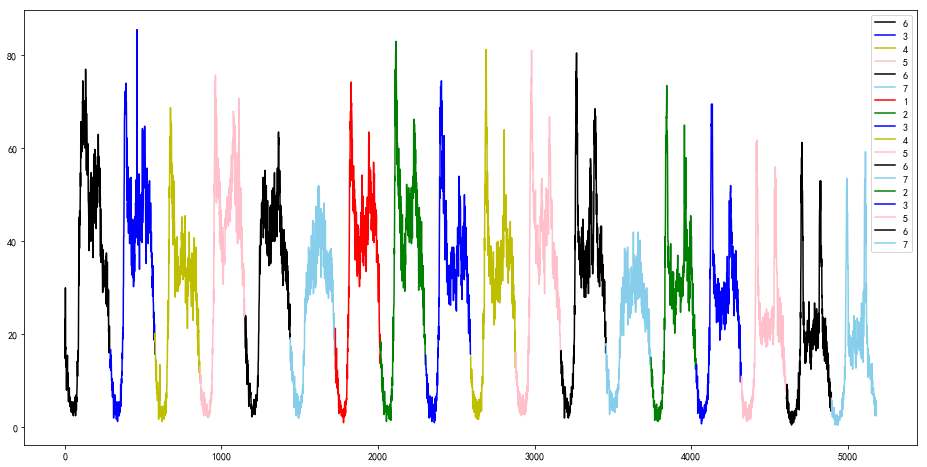

In [212]:
plt.figure(figsize=(16,8))
colors=['r','g','b','y','pink','black','skyblue']
for d in train_data.day_tag.unique():
    tmp=train_data.loc[train_data.day_tag==d]
    plt.plot(tmp.index,tmp.number,color=colors[int(tmp.weekday.unique()[0]*6)],label=int(tmp.weekday.unique()[0]*6+1))
plt.legend()

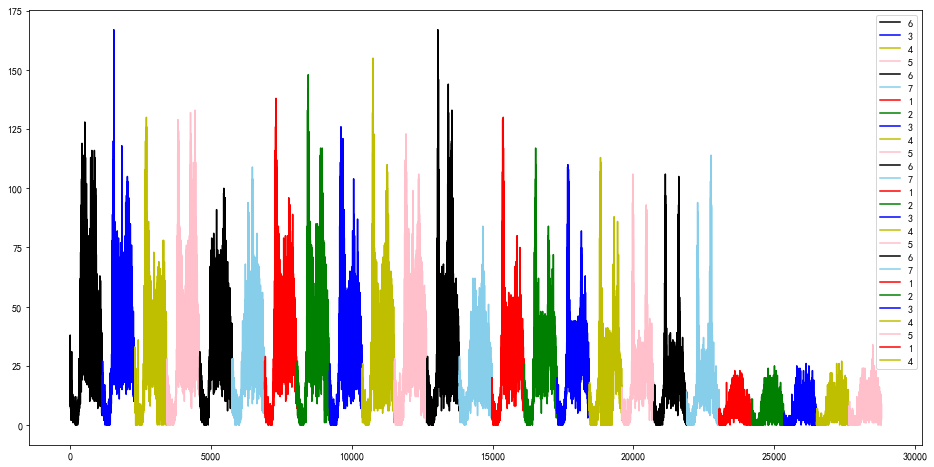

In [250]:
plt.figure(figsize=(16,8))
colors=['r','g','b','y','pink','black','skyblue']
for d in day_data.day_tag.unique():
    tmp=day_data.loc[day_data.day_tag==d]
    plt.plot(tmp.index,tmp.number,color=colors[int(tmp.weekday.unique()[0]*6)],label=int(tmp.weekday.unique()[0]*6+1))
plt.legend()

In [172]:
result_data=[14.0, 17.0, 16.0, 19.0, 16.5, 16.5, 14.5, 23.0, 21.5, 21.5, 21.5, 24.5, 29.0, 30.5, 34.5, 41.5, 39.0, 38.5, 56.0, 57.5, 63.5, 56.0, 70.5, 69.5, 79.5, 99.0, 94.5, 102.0, 123.0, 156.5, 161.0, 189.0, 131.66666666666666, 159.33333333333334, 253.0, 279.5, 251.0, 294.5, 273.0, 303.0, 279.5, 268.0, 268.0, 266.5, 244.5, 255.5, 216.0, 194.5, 202.5, 196.0, 172.5, 194.5, 186.0, 177.5, 177.5, 170.5, 186.0, 171.0, 174.5, 159.5, 160.5, 158.5, 154.0, 155.5, 162.5, 190.0, 139.5, 152.5, 148.0, 160.5, 129.5, 152.5, 140.0, 131.0, 130.5, 140.0, 123.5, 134.0, 134.0, 153.5, 147.5, 141.5, 131.0, 145.0, 114.0, 135.5, 127.5, 109.5, 129.0, 124.0, 123.5, 118.5, 118.5, 112.5, 116.5, 108.0, 114.5, 134.5, 116.5, 127.5, 133.0, 136.0, 146.5, 151.0, 148.5, 156.5, 155.0, 172.5, 157.0, 158.0, 164.5, 153.0, 148.5, 150.5, 150.0, 141.5, 148.5, 142.5, 156.5, 154.5, 165.5, 148.0, 144.0, 158.5, 153.0, 140.0, 156.5, 141.5, 150.0, 99.33333333333333, 158.5, 151.5, 140.0, 160.5, 98.0, 155.5, 145.5, 162.5, 142.5, 154.5, 157.0, 155.0, 151.0, 151.0, 92.0, 169.0, 170.0, 172.5, 176.5, 172.5, 176.5, 194.5, 227.5, 262.5, 224.0, 213.0, 223.5, 202.0, 230.5, 222.0, 231.0, 195.0, 233.5, 202.5, 208.0, 187.5, 181.0, 129.0, 108.66666666666667, 179.0, 190.5, 159.0, 153.0, 165.5, 171.5, 154.5, 173.5, 147.5, 144.0, 143.5, 141.0, 155.0, 149.5, 131.5, 109.0, 125.0, 135.0, 118.0, 183.0, 148.0, 150.5, 169.5]+[13.5, 21.5, 21.5, 13.5, 19.0, 13.5, 20.0, 27.5, 24.5, 20.0, 26.0, 28.0, 29.5, 24.5, 32.0, 31.0, 44.0, 46.0, 42.5, 67.0, 57.0, 76.5, 70.5, 80.0, 82.5, 92.5, 115.5, 101.0, 160.0, 153.0, 194.0, 199.5, 224.0, 243.5, 249.5, 274.0, 286.5, 276.0, 291.5, 277.0, 286.5, 290.0, 258.5, 281.0, 220.0, 266.0, 255.5, 225.5, 225.5, 234.5, 224.5, 200.5, 213.5, 210.0, 203.5, 189.5, 201.0, 203.0, 199.0, 200.5, 189.5, 193.5, 191.5, 190.0, 178.0, 179.5, 188.0, 174.5, 175.5, 176.0, 172.0, 155.0, 165.5, 172.0, 167.5, 154.0, 157.5, 169.5, 143.5, 158.0, 165.5, 149.5, 157.0, 146.5, 160.5, 146.5, 148.5, 153.5, 133.5, 140.5, 136.5, 152.0, 141.0, 140.5, 136.5, 147.5, 158.0, 164.5, 159.5, 159.5, 181.0, 185.5, 174.5, 184.0, 198.0, 186.5, 189.0, 193.5, 172.0, 178.5, 196.5, 180.5, 173.0, 167.5, 182.5, 180.5, 171.0, 178.5, 185.5, 177.5, 158.0, 165.5, 171.5, 160.5, 160.5, 167.5, 168.5, 177.0, 187.0, 181.5, 180.0, 194.5, 196.0, 180.5, 183.0, 202.0, 194.0, 179.5, 180.5, 193.5, 205.0, 187.0, 188.0, 216.5, 200.0, 203.5, 204.0, 216.5, 204.5, 201.0, 213.5, 248.5, 225.0, 258.0, 243.5, 258.5, 251.5, 254.5, 234.0, 232.0, 227.0, 221.5, 239.5, 226.0, 193.5, 192.5, 207.5, 195.5, 191.0, 199.0, 201.5, 187.0, 171.0, 191.0, 174.0, 180.5, 171.5, 180.5, 188.5, 145.0, 168.0, 143.5, 178.5, 174.0, 158.0, 172.5, 165.0, 212.5, 198.0, 214.5, 184.0, 176.0]
half=(len(result_data)//2)
r1=result_data[:half]
r2=result_data[half:]
result_data=[0.725*i for i in r1]+[0.8*i for i in r2]

In [173]:
new_mean=(mean_answer.number*4).tolist()
half=(len(new_mean)//2)
m1=new_mean[:half]
m2=new_mean[half:]
new_mean=[0.725*i for i in m1]+[1*i for i in second_mean[half:]]

In [50]:
new_test_mean2=[i for index,i in enumerate(new_mm1)]+[i if (index>=32 and index <=46) else i*1.1 for index,i in enumerate(combine)]
new_test_mean2=smoth(new_test_mean2,250,335)

In [271]:
pred_fix=pred.copy()
pred_fix[240:335]+=45
pred_fix[55:140]+=17

In [280]:
fix_new_test_mean1=np.array(new_test_mean1)
fix_new_test_mean1[70:140]=(pred_fix[70:140]*2+fix_new_test_mean1[70:140])/3

In [22]:
print(np.ceil(new_test_mean).tolist())

[14.0, 17.0, 15.0, 17.0, 16.0, 19.0, 22.0, 23.0, 20.0, 21.0, 23.0, 24.0, 28.0, 30.0, 29.0, 27.0, 35.0, 35.0, 44.0, 42.0, 48.0, 49.0, 43.0, 57.0, 69.0, 65.0, 69.0, 80.0, 94.0, 112.0, 123.0, 137.0, 168.0, 190.0, 208.0, 231.0, 239.0, 251.0, 239.0, 251.0, 257.0, 232.0, 223.0, 228.0, 198.0, 181.0, 174.0, 129.0, 127.0, 126.0, 124.0, 124.0, 110.0, 109.0, 108.0, 108.0, 98.0, 106.0, 105.0, 103.0, 98.0, 99.0, 98.0, 102.0, 92.0, 95.0, 92.0, 97.0, 94.0, 96.0, 89.0, 88.0, 97.0, 101.0, 90.0, 96.0, 92.0, 94.0, 93.0, 106.0, 91.0, 101.0, 97.0, 93.0, 96.0, 92.0, 90.0, 95.0, 89.0, 91.0, 87.0, 84.0, 93.0, 80.0, 86.0, 87.0, 84.0, 83.0, 88.0, 91.0, 91.0, 95.0, 98.0, 99.0, 96.0, 105.0, 99.0, 99.0, 95.0, 108.0, 102.0, 99.0, 100.0, 99.0, 105.0, 99.0, 106.0, 93.0, 102.0, 97.0, 105.0, 102.0, 91.0, 100.0, 97.0, 101.0, 104.0, 95.0, 95.0, 107.0, 93.0, 95.0, 100.0, 103.0, 97.0, 103.0, 98.0, 101.0, 102.0, 110.0, 97.0, 99.0, 99.0, 101.0, 104.0, 110.0, 117.0, 115.0, 111.0, 113.0, 148.0, 171.0, 197.0, 210.0, 166.0, 168.

In [180]:
new_test_mean=[i*1.05 if (index>=342 and index <=359) else i for index, i in enumerate(new_test_mean)]
# new_test_mean=[i*1.1 if (index>=163 and index <=192) else i for index, i in enumerate(new_test_mean)]

In [181]:
second_mean=second_week.groupby(['timeindex','weekday']).mean().reset_index(level=['timeindex','weekday'])
second_mean=second_mean.loc[(second_mean.weekday==0)|(second_mean.weekday==0.5)]
second_mean=second_mean.loc[(second_mean.timeindex>=0.20832)&(second_mean.timeindex<0.8716)]
second_mean.sort_values(['weekday','timeindex'],inplace=True)
second_mean=(second_mean.number.values*4).tolist()
print(len(second_mean))

384


In [258]:
import math

In [84]:
print(np.round(new_test_mean).tolist())

[14.0, 17.0, 15.0, 16.0, 15.0, 19.0, 21.0, 23.0, 19.0, 21.0, 22.0, 23.0, 27.0, 29.0, 29.0, 27.0, 34.0, 34.0, 43.0, 41.0, 48.0, 49.0, 42.0, 56.0, 68.0, 65.0, 69.0, 79.0, 94.0, 112.0, 123.0, 136.0, 168.0, 190.0, 208.0, 231.0, 238.0, 251.0, 239.0, 251.0, 256.0, 232.0, 223.0, 228.0, 197.0, 180.0, 173.0, 129.0, 126.0, 126.0, 124.0, 123.0, 110.0, 108.0, 107.0, 107.0, 97.0, 106.0, 105.0, 102.0, 97.0, 99.0, 98.0, 101.0, 92.0, 95.0, 91.0, 97.0, 93.0, 96.0, 89.0, 88.0, 96.0, 101.0, 90.0, 96.0, 91.0, 93.0, 93.0, 105.0, 91.0, 100.0, 96.0, 93.0, 96.0, 92.0, 90.0, 95.0, 89.0, 90.0, 87.0, 83.0, 92.0, 80.0, 86.0, 87.0, 84.0, 82.0, 87.0, 90.0, 91.0, 95.0, 98.0, 98.0, 96.0, 104.0, 99.0, 99.0, 95.0, 107.0, 102.0, 98.0, 100.0, 98.0, 104.0, 99.0, 105.0, 92.0, 102.0, 96.0, 105.0, 101.0, 91.0, 100.0, 97.0, 101.0, 103.0, 95.0, 95.0, 107.0, 93.0, 95.0, 100.0, 103.0, 97.0, 103.0, 97.0, 101.0, 102.0, 110.0, 97.0, 98.0, 98.0, 100.0, 103.0, 110.0, 117.0, 114.0, 111.0, 113.0, 148.0, 171.0, 196.0, 210.0, 166.0, 168.

In [26]:
predict_trend=[6.940100284242915, 7.97710268093583, 7.087815701687161, 8.6066709408936, 7.071100827368608, 8.463251137508555, 11.63704646893214, 13.93953034891674, 11.947979440157985, 11.934014490979905, 11.956026548126388, 14.272511232197187, 16.982568562834278, 20.533432937864607, 21.42844138398512, 20.598852419900773, 25.27290745478975, 24.960304389955894, 32.915239219602036, 35.125378364072354, 48.5639323506274, 48.912449791873456, 42.89568664120832, 51.1091534415388, 61.97650404054924, 59.44471129773165, 60.659436762759455, 74.0569960453489, 103.22770183617315, 117.81224054637407, 132.46532851568716, 140.55940271326153, 171.0724116186749, 188.21784134490986, 208.0527488674869, 226.44346405616258, 236.01037041731635, 249.35716958887204, 239.26785901452425, 249.29428039979305, 249.29428039979305, 235.58126359155014, 223.49316863763556, 231.64249990088862, 204.22571286790355, 184.75476784615194, 164.6629517998963, 138.37340876257144, 132.34753022511498, 128.16814654121598, 128.2750033215475, 128.46511840068436, 112.2171166856934, 112.2171166856934, 117.48440010699588, 106.18755813402322, 103.37867157780809, 110.59530773750204, 107.38010886195359, 106.55816520108142, 105.49564783907755, 105.49564783907755, 106.15100977686237, 105.22922766721382, 98.29752435868974, 98.3918532337532, 95.43472342247772, 97.80295761019649, 97.80295761019649, 97.80295761019649, 90.48216783678923, 94.2125210502134, 99.69127117731182, 101.07292472957066, 96.65695001882806, 96.65695001882806, 90.33552962138258, 95.70277907894311, 93.14689127173321, 106.0407683307833, 95.0187654576941, 94.20307471852321, 94.91784937343348, 92.47842547068103, 92.74535426161407, 93.08647088815201, 93.08647088815201, 93.08647088815201, 85.84542607446461, 85.84542607446461, 83.57173121553755, 77.78335487739751, 88.86762637731078, 83.30625604406497, 81.91270912098462, 83.77897277409475, 84.10353919665549, 84.10353919665549, 91.63843336936942, 92.4848266099859, 92.4848266099859, 92.11262956493708, 96.11690008465476, 99.47351325047491, 99.47351325047491, 100.44692678395037, 103.21050221793847, 101.0600674885536, 101.0600674885536, 107.15457534811729, 103.00909169901507, 104.56037222495344, 103.51017146157922, 97.23651664915565, 98.74447335292247, 100.65915281144201, 104.11975570141233, 97.27956859394895, 100.4336113102336, 100.4336113102336, 97.73196130817703, 102.76061555740185, 94.32911291991488, 98.41094047854327, 98.41094047854327, 98.41094047854327, 98.41094047854327, 98.22098663879325, 101.28762281873658, 107.52356564685847, 94.35663774986236, 97.5326611967508, 100.65493460561373, 103.52143299336787, 98.00061928985451, 108.22148487797237, 101.57069302270632, 101.03505911450162, 104.01504771234801, 111.33636196767898, 100.23919270819086, 101.46961896133696, 104.12693258719885, 103.69189001507412, 105.69241569487578, 111.00226877177683, 117.89604878807533, 114.16712884198188, 110.1484750661603, 110.1484750661603, 129.6322876540246, 162.63259687614993, 181.74156927352058, 193.0016937797943, 168.9301330392632, 165.8900153142163, 173.89704805489305, 177.9102655267039, 185.13097755904082, 186.3099271644055, 184.09648643030246, 169.30627006253675, 171.64245514013552, 163.06624902429803, 158.50627276344085, 158.04627103916712, 147.3802995217423, 142.4104059386041, 132.0619340084988, 126.09963619211764, 115.6192605962999, 114.39448395180227, 114.3259088942255, 120.24746136729445, 114.32054159503063, 115.18708569483393, 120.29608641179252, 110.96310560447554, 105.82791463080287, 106.69944094102664, 94.40010992813039, 96.49772780935187, 117.62936041098777, 92.09218480895788, 105.51227699525316, 103.22417228713252, 102.18824789627597, 113.05491866702998, 127.42157885107156, 127.1449065924014, 126.69040699080713, 115.87844741212105, 23.030684217769306, 27.570183761475015, 26.680896782226334, 27.080193115701636, 25.045926508542316, 26.24606945222681, 33.26257592581518, 34.71050514124508, 32.47049228340517, 32.29261249267776, 36.94042570268241, 38.60083730722987, 41.31089463786695, 44.861759012897224, 45.75676745901774, 44.927178494933415, 49.60123352982241, 49.3624929658036, 57.31742779544982, 59.52756693992026, 75.08966569137493, 75.43818313262099, 76.49409196691879, 84.70755876724928, 95.57490936625956, 95.31388309704458, 97.46796808760412, 110.86552737019325, 140.03623316101738, 154.62077187121838, 169.27385984053188, 180.74226145305792, 211.25527035847128, 228.40070008470624, 248.2356076072833, 266.6263227959565, 278.1363856037276, 291.83016525010714, 281.7408546757591, 291.76727606102764, 291.76727606102764, 278.05425925278473, 265.47849433099975, 273.2678228494479, 245.85103581646658, 226.38009079471496, 206.28827474845932, 176.94681243478817, 170.9209338973317, 166.7415502134327, 166.84840699376423, 167.0385220729011, 149.52489230475473, 149.52489230475473, 152.93282204391258, 141.63598007093995, 138.66741182734856, 144.0118691049142, 140.79667022936576, 139.97472656849362, 138.91220920648976, 138.91220920648976, 139.56757114427464, 138.64578903462615, 131.7140857261021, 131.80841460116557, 128.85128478989006, 131.21951897760874, 131.21951897760874, 131.21951897760874, 121.13223087694334, 124.86258409036753, 127.83912538187053, 129.22077893413058, 124.65978149873679, 124.65978149873679, 118.1213411968421, 123.48859065440263, 120.93270284719273, 132.77376300999217, 121.75176013690168, 120.93606939773079, 121.65084405264106, 119.21142014988861, 119.47834894082165, 119.81946556735959, 119.81946556735959, 119.81946556735959, 112.57842075367219, 112.57842075367219, 110.30472589474513, 104.51634955660509, 115.60062105651836, 110.03925072327254, 108.6457038001922, 110.51196745330233, 110.83653387586307, 110.83653387586307, 118.371428048577, 119.21782128919348, 119.21782128919348, 118.84562424414466, 122.84989476386234, 126.2065079296826, 126.2065079296826, 127.1799214631583, 129.9434968971478, 127.79306216776291, 127.79306216776291, 133.8875700273265, 129.74208637822431, 131.29336690416272, 130.24316614078845, 123.96951132836321, 125.47746803212998, 127.39214749065026, 130.85275038062142, 124.0125632731567, 127.16660598944132, 127.16660598944132, 124.66666272535312, 129.6953169745794, 121.26381433709078, 125.34564189571917, 125.34564189571917, 125.34564189571917, 125.34564189571917, 125.15568805596915, 129.8656169537971, 136.10155978191904, 123.62648295924035, 126.8025064061291, 130.69640643790433, 133.56290482565848, 128.12767322907314, 138.72496248618694, 132.11660747205724, 131.5809735638525, 135.00741919554034, 142.3287334508714, 131.59562371240625, 132.8260499655524, 135.48336359141427, 135.04832101928952, 137.0488466990912, 142.3586997759923, 149.25247979229073, 146.87028113914073, 144.58439597533172, 144.58439597533172, 163.21430794644, 196.21461716856533, 215.8118902938009, 227.0720148000746, 203.39554783990295, 200.35543011485603, 208.62108814540298, 212.63430561721384, 219.85501764955075, 221.03396725491544, 218.8205265208124, 205.14423340186727, 207.48041847946604, 198.90421236362852, 194.34423610277136, 193.88423437849764, 183.21826286107282, 178.24836927793461, 167.8998973478293, 161.93759953144962, 151.45722393563173, 150.23244729113406, 150.16387223355733, 156.08542470662596, 150.1005130466987, 150.43848754392062, 154.70515444781768, 143.60221677698755, 138.4670258033148, 139.18891335671313, 126.6155182001333, 128.56312613915503, 149.69475874079097, 124.03331992694756, 137.45341211324416, 135.16530740512346, 134.12938301426698, 144.9960537850209, 159.36271396906255, 159.08604171039238, 158.63154210879796, 146.87836849803313]

In [284]:
print(fix_new_test_mean1.tolist())

[13.571428571428571, 16.571428571428573, 15.0, 16.285714285714285, 15.285714285714286, 18.571428571428573, 21.428571428571427, 22.714285714285715, 19.428571428571427, 20.571428571428573, 22.142857142857142, 23.142857142857142, 27.428571428571427, 29.285714285714285, 28.857142857142858, 26.857142857142858, 34.285714285714285, 34.42857142857143, 43.142857142857146, 41.142857142857146, 47.857142857142854, 49.0, 42.285714285714285, 56.142857142857146, 68.42857142857143, 64.85714285714286, 68.57142857142857, 79.42857142857143, 93.71428571428571, 112.0, 122.57142857142857, 136.14285714285714, 167.57142857142858, 190.0, 207.57142857142858, 231.0, 238.28571428571428, 251.0, 239.0, 250.71428571428572, 256.14285714285717, 232.0, 222.71428571428572, 228.0, 197.14285714285714, 180.28571428571428, 173.14285714285714, 129.0, 126.42857142857143, 125.85714285714286, 123.57142857142857, 123.42857142857143, 109.71428571428571, 108.14285714285714, 107.42857142857143, 107.14285714285714, 97.28571428571429

In [15]:
mean_answer=day_data.loc[((day_data.day_tag<=203))]
mean_answer=mean_answer.groupby(['timeindex','weekday']).mean().reset_index(level=['timeindex','weekday'])
mean_answer=mean_answer.loc[(mean_answer.weekday==0)|(mean_answer.weekday==0.5)]
print(mean_answer.shape)
mean_answer=mean_answer.loc[(mean_answer.timeindex>=0.20832)&(mean_answer.timeindex<0.8716)]
mean_answer.sort_values(['weekday','timeindex'],inplace=True)
print(mean_answer.shape)

(576, 19)
(384, 19)


In [258]:
mean_answer.number.values*3.2

384

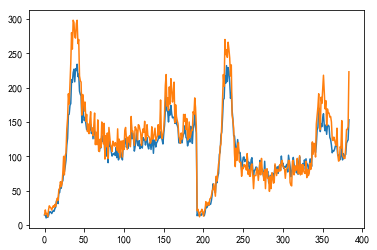

In [256]:
plt.plot(range(mean_answer.shape[0]),mean_answer.number.values*3.2)
# plt.plot(range(mean_answer.shape[0]),mean_answer.number.values*3.7)
plt.plot(range(new_mean.shape[0]),new_mean.number.values*4)

In [101]:
# def regression_loss(y, pred):
#     x=np.square(pred-y).astype("float")
#     p=1/(1+np.exp(-x).astype("float"))
#     grad = p*(1-p)*2*(pred-y)
#     hess = (2*p+4*x*(p-3*np.power(p,2)-2*np.power(p,3))-2*np.power(p,2))
#     return grad, hess
def regression_loss(y, pred):
    x=np.square(pred-y).astype("float")
    p=1/(1+np.exp(-x).astype("float"))
    grad = p*(1-p)*2*(pred-y)*(y/np.sum(y))
    hess = np.ones(len(grad))*2*(y/np.sum(y))
    return grad, hess


def custom_asymmetric_train(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -2*10.0*residual, -2*residual)
    hess = np.where(residual<0, 2*10.0, 2.0)
    return grad, hess


In [150]:
# mean_trend.rename(columns={'number':'means_number'},inplace=True)
# train_data=train_data.merge(mean_trend,on=['weekday','timeindex','direction'],how='left')
print(train_data.shape)
# train_data['resid']=train_data.number-train_data.means_number
# val_data=val_data.merge(mean_trend,on=['weekday','timeindex','direction'],how='left')
# val_data['resid']=val_data.number-val_data.means_number
print(val_data.shape)
#--------
test_data=day_data.loc[day_data.isTest==1]
# test_data=test_data.groupby(["weekday", "timeindex",'day_tag']).mean().reset_index(level = ["weekday", "timeindex",'day_tag'])
# print(test_data.shape)
# test_data.loc[test_data.weekday==0,'means_number']=mean_trend.loc[(mean_trend.timeindex>0.2083)&(mean_trend.timeindex<0.8716)&(mean_trend.weekday==0),'means_number'].values
# test_data.loc[test_data.weekday==0.5,'means_number']=mean_trend.loc[(mean_trend.timeindex>0.2083)&(mean_trend.timeindex<0.8716)&(mean_trend.weekday==0.5),'means_number'].values
# print(test_data.shape)

(49536, 22)


In [50]:
test_df.columns

Index(['weekday', 'timeindex', 'isTest', 'tag_112', 'tag_116', 'tag_117',
       'tag_118', 'tag_119', 'tag_120', 'tag_121', 'tag_122', 'tag_123',
       'tag_124', 'tag_125', 'tag_126', 'tag_127', 'tag_128', 'tag_129',
       'tag_130', 'tag_131', 'tag_201', 'tag_202', 'tag_203', 'tag_204',
       'tag_205', 'tag_206', 'tag_207', 'tag_208', 'number',
       'diff_last_number', 'diff112', 'diff116', 'diff117', 'diff118',
       'diff119', 'diff120', 'diff121', 'diff122', 'diff123', 'diff124',
       'diff125', 'diff126', 'diff127', 'diff128', 'diff129', 'diff130',
       'diff131', 'diff201', 'diff202', 'diff203', 'diff204', 'diff205',
       'diff206', 'diff207', 'diff208', 'predict'],
      dtype='object')

In [174]:
feature_col=['weekday','timeindex','weather', 'temperature_high', 'temperature_low','day_tag','last_number',
              'diff_last_number','holiday_gap', 'holiday']#, ,'last_number', 'last_left', 'last_straight','diff_last_number', 'diff_last_left',
#             'diff_last_st`raight',

In [62]:
feature_col=['weekday', 'timeindex', 'tag_112', 'tag_116', 'tag_117',
       'tag_118', 'tag_119', 'tag_120', 'tag_121', 'tag_122', 'tag_123',
       'tag_124', 'tag_125', 'tag_126', 'tag_127', 'tag_128', 'tag_129',
       'tag_130', 'tag_131', 'tag_201', 'tag_202', 'tag_203', 'tag_204',
       'tag_205', 'tag_206', 'tag_207', 'tag_208']

In [63]:
import lightgbm as lgb
clf=lgb.LGBMRegressor( n_estimators=800,
          num_leaves=50,
          max_depth= 2, 
          min_samples_split= 2,
          learning_rate=0.05,
#         objective=custom_asymmetric_train,
        reg_alpha=0.5,
        reg_lambda=5,
) 
 
#把我们自定义的Loss函数设为objective，也可以在实例化gbm的时候这样做
# clf.set_params(**{}, metrics = ["mse"])
 
clf=clf.fit(
   X=test_df[feature_col],y=test_df['number'],
    eval_set=[(test_df[feature_col],test_df['number'])],
    eval_metric=['mse'],early_stopping_rounds=50,
    verbose=50
)
test_df['predict']=clf.predict(test_df[feature_col])
# val_data['predict']=clf.predict(val_data[feature_col])
# test_data['predict']=clf.predict(test_data[feature_col])
# train_data['predict']=clf.predict(train_data[feature_col])

Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 203.977
[100]	valid_0's l2: 52.0275
[150]	valid_0's l2: 35.6743
[200]	valid_0's l2: 31.5487
[250]	valid_0's l2: 28.9418
[300]	valid_0's l2: 27.4122
[350]	valid_0's l2: 26.6161
[400]	valid_0's l2: 26.0617
[450]	valid_0's l2: 25.6516
[500]	valid_0's l2: 25.3607
[550]	valid_0's l2: 25.1363
[600]	valid_0's l2: 24.9688
[650]	valid_0's l2: 24.8388
[700]	valid_0's l2: 24.7351
[750]	valid_0's l2: 24.6352
[800]	valid_0's l2: 24.5596
Did not meet early stopping. Best iteration is:
[800]	valid_0's l2: 24.5596


In [164]:
params = {'n_estimators': 1000,
          'num_leaves': 50,
          'max_depth': -1, 
          'min_samples_split': 2,
          'learning_rate': 0.05,
#           'reg_lambda':0.2,
#           'loss': 'ls',
#           'objective':regression_loss,#'regression',#regression_l2,regression_l1,huber,poisson,quantile
          'metric': ['mse']
         }

lgb_train=lgb.Dataset(train_data[feature_col],train_data.number*4,free_raw_data=False)
lgb_val=lgb.Dataset(val_data[feature_col], val_data.number*4,reference=lgb_train, free_raw_data=False)
clf = lgb.train(params,train_set=lgb_train,valid_sets=lgb_val,verbose_eval=50,early_stopping_rounds=50,
#                fobj=regression_loss,
#                 feval=custom_f1_eval,
               )
val_data['predict']=clf.predict(val_data[feature_col])

Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 1054.96
Early stopping, best iteration is:
[49]	valid_0's l2: 1054.56


d:\python3.5\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [56]:
sorted(dict(zip(feature_col,clf.feature_importances_)).items(),key=lambda x:x[1],reverse=True)

[('diff_last_number', 461),
 ('weekday', 244),
 ('diff130', 164),
 ('tag_203', 104),
 ('tag_130', 61),
 ('timeindex', 54),
 ('diff201', 48),
 ('diff124', 46),
 ('tag_118', 44),
 ('tag_201', 44),
 ('tag_124', 43),
 ('tag_131', 42),
 ('diff131', 42),
 ('diff123', 42),
 ('tag_127', 41),
 ('diff202', 39),
 ('tag_202', 36),
 ('diff121', 35),
 ('diff117', 34),
 ('tag_122', 31),
 ('tag_125', 29),
 ('tag_126', 29),
 ('tag_117', 28),
 ('tag_129', 26),
 ('diff205', 25),
 ('diff208', 24),
 ('diff128', 23),
 ('diff126', 22),
 ('diff119', 21),
 ('tag_120', 20),
 ('tag_116', 20),
 ('diff116', 20),
 ('diff118', 19),
 ('tag_123', 18),
 ('diff122', 16),
 ('diff207', 14),
 ('tag_119', 14),
 ('tag_128', 12),
 ('diff125', 12),
 ('tag_112', 11),
 ('diff112', 7),
 ('diff203', 6),
 ('diff204', 6),
 ('tag_206', 5),
 ('tag_121', 4),
 ('tag_208', 4),
 ('diff120', 4),
 ('tag_207', 4),
 ('tag_204', 3),
 ('diff129', 3),
 ('tag_205', 1),
 ('diff206', 1),
 ('diff127', 1)]

In [671]:
val_data['pro_predict']=val_data.groupby(['direction','day_tag'])['predict'].transform(emitter_data)
mse = mean_squared_error(val_data['number']*4,val_data['predict'])
fix_mse=mean_squared_error(val_data['number']*4,val_data['pro_predict'])
print("MSE: %.4f" % mse)
print("fix MSE:%.4f" % fix_mse)

MSE: 437.3472
fix MSE:593.7355


In [189]:
# test_data=test_data.merge(mean_trend,on=['weekday','timeindex'],how='left')
# test_data=day_data.loc[day_data.isTest==1]
# print(test_data.shape)
test_data['predict']=clf.predict(test_data[feature_col])
# test_data['pro_predict']=test_data.groupby(['day_tag'])['predict'].transform(emitter_data)

d:\python3.5\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [261]:
test_data=test_data.groupby(["weekday", "timeindex",'day_tag']).mean().reset_index(level = ["weekday", "timeindex",'day_tag'])
print(test_data.shape)
train_data=train_data.groupby(["weekday", "timeindex",'day_tag']).mean().reset_index(level = ["weekday", "timeindex",'day_tag'])
val_data=val_data.groupby(["weekday", "timeindex",'day_tag']).mean().reset_index(level = ["weekday", "timeindex",'day_tag'])

(384, 20)


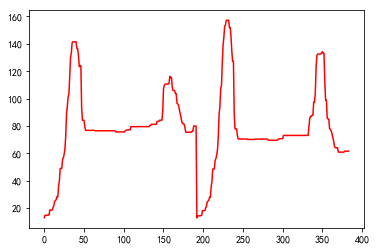

In [249]:
plt.figure()
plt.plot((test_data.loc[:,'predict']),color='r')
# plt.plot(test_data.trend_number*4)

In [652]:
train_data['predict']=clf.predict(train_data[feature_col])


In [1113]:
mean_trend.loc[(mean_trend.timeindex>0.2083)&(mean_trend.timeindex<0.8716)&(mean_trend.weekday==0)].shape

(192, 3)

In [1157]:
test_data.loc[test_data.weekday==0,'means_number']=mean_trend.loc[(mean_trend.timeindex>0.2083)&(mean_trend.timeindex<0.8716)&(mean_trend.weekday==0),'means_number'].values
test_data.loc[test_data.weekday==0.5,'means_number']=mean_trend.loc[(mean_trend.timeindex>0.2083)&(mean_trend.timeindex<0.8716)&(mean_trend.weekday==0.5),'means_number'].values

In [1164]:
plt.plot(test_data.loc[:,'predict'].values+test_data.means_number.values)*3.95
mean_trend.loc[(mean_trend.timeindex>0.2083)&(mean_trend.timeindex<0.8716)&(mean_trend.weekday==0),'means_number'].values

array([ 17.99416844,  12.9337675 ,   9.25950863,  18.03135144,
        14.38383219,   8.76617788,  15.9850215 ,  20.82321213,
        19.85286396,  16.05435671,  20.64525909,  22.79821213,
        22.44133335,  28.9501969 ,  37.45883855,  53.23630397,
        45.05747298,  40.93303661,  66.4751969 ,  62.89317794,
        80.66817794,  75.73067794,  94.49317794,  81.62055928,
        92.07347317, 117.95053249, 106.2980772 , 132.08904471,
       160.08713667, 175.59791022, 229.16265514, 245.53293178,
       253.11604752, 230.10360898, 279.55186281, 299.05374614,
       292.1778599 , 307.88054118, 283.27089797, 332.62874614,
       305.09564801, 320.51851252, 308.34236087, 309.45412894,
       300.55954856, 277.0156542 , 273.59270915, 210.57227679,
       244.05266327, 214.90630134, 209.0179151 , 198.42862317,
       199.59393138, 166.34875306, 190.91575651, 179.20311668,
       204.48585818, 174.63136448, 182.78507686, 176.95448602,
       191.64835818, 163.59949092, 185.44135255, 157.05

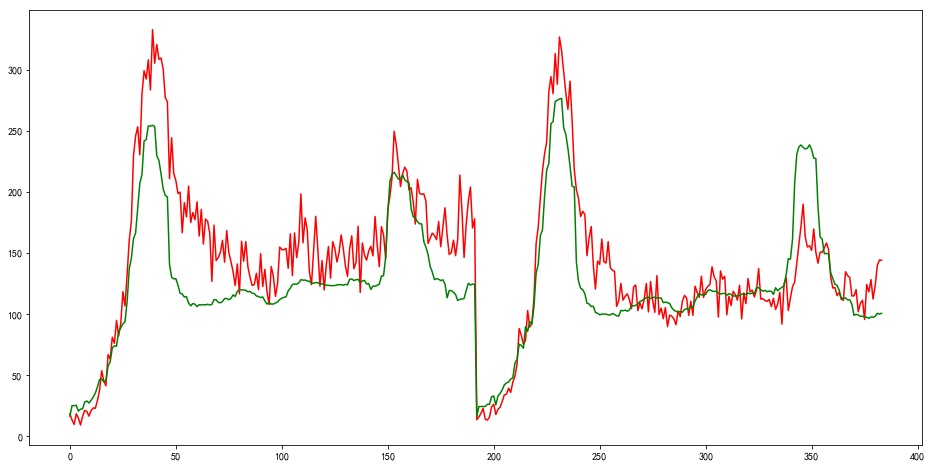

In [1162]:
plt.figure(figsize=(16,8))
# plt.plot(val_data['number']*4,color='g')
plt.plot((test_data.loc[:,'predict']+test_data.means_number)*3.95,color='r')
# plt.plot(test_data.loc[test_data.weekday==0.5,'predict'],color='g',alpha=0.7)
# plt.plot(mean_test.number*4,color='g')
plt.plot(result_data,color='g')
# plt.plot(mean_trend.means_number*4,color='g')

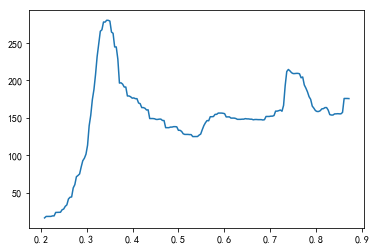

In [606]:
plt.plot(test_data.loc[test_data.weekday==0,'timeindex'],test_data.loc[test_data.weekday==0,'predict'])

In [127]:
val_data=val_data.groupby(["weekday", "timeindex",'day_tag']).mean().reset_index(level = ["weekday", "timeindex",'day_tag'])

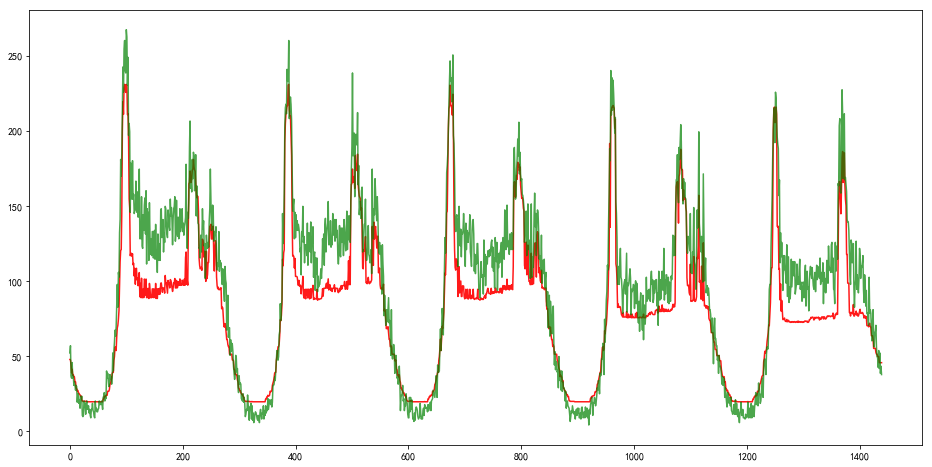

In [180]:
plt.figure(figsize=(16,8))
# plt.plot(val_data['number']*4,color='g')
plt.plot((val_data.loc[:,'predict']),color='r',alpha=0.9)
plt.plot(val_data.loc[:,'number']*4,color='g',alpha=0.7)
# plt.plot(val_data.loc[:,'trend_number']*4,color='g',alpha=0.7)
# plt.plot((val_data.loc[:,'predict']+val_data.means_number)*3.8,color='r')

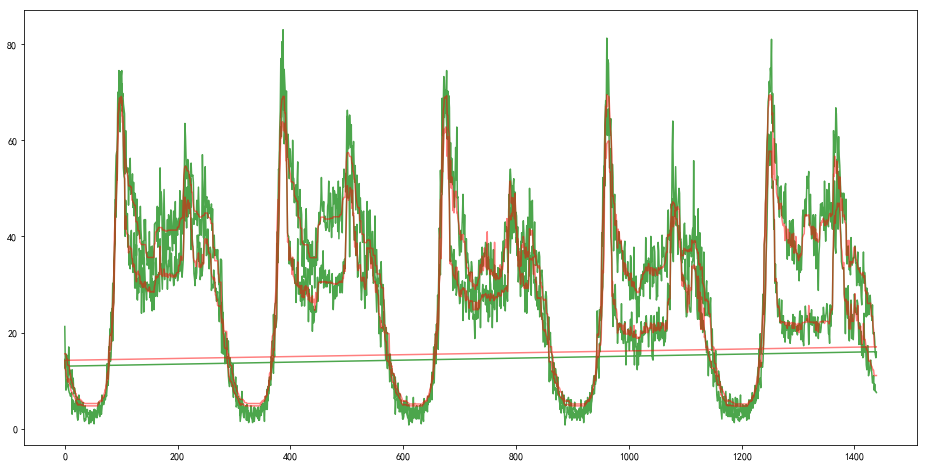

In [177]:
plt.figure(figsize=(16,8))
# train_data['predict']=clf.predict(train_data[feature_col])
# train_data=train_data.groupby(["weekday", "timeindex",'day_tag']).mean().reset_index(level = ["weekday", "timeindex",'day_tag'])
plt.plot(train_data.loc[:,'number'],color='g',alpha=0.7)
plt.plot(train_data.loc[:,'predict'],color='r',alpha=0.5)
# plt.plot((train_data.loc[:,'predict'][300:2000]+train_data.means_number[300:2000])*4,color='r',alpha=0.5)

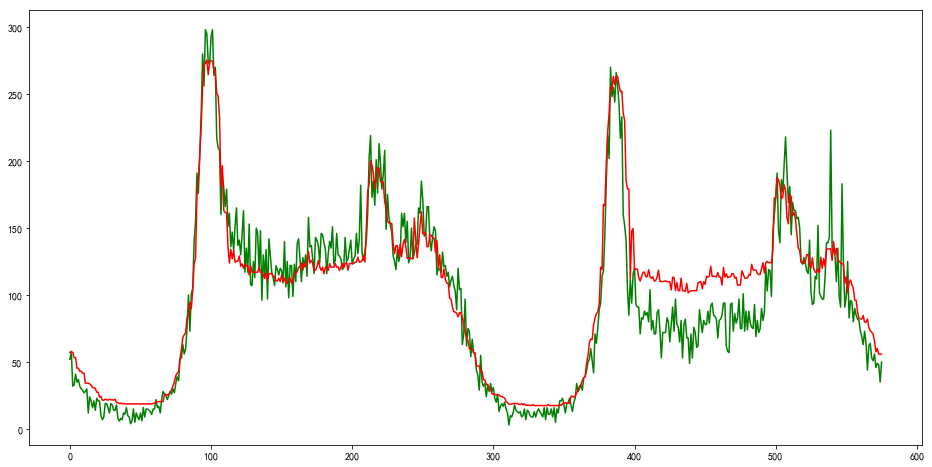

In [830]:
# plt.figure(figsize=(16,8))
# plt.plot(train_data['number'][1000:5000],color='g',alpha=0.6)
# # plt.plot(train_data['predict'][1000:5000],color='r')
# plt.plot(train_data['pro_predict'][1000:5000],color='r')
plt.figure(figsize=(16,8))
plt.plot(val_data['number']*4,color='g')
plt.plot(val_data['predict'],color='r')
# plt.plot(val_data['pro_predict'],color='r')

In [239]:
feature_col=['weekday','timeindex']
params = {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 2,
          'learning_rate': 0.03, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)
clf.fit(train_data[feature_col], train_data['number']*4)
# joblib.dump(clf, LOCAL_MODEL_PATH)

y_predict = clf.predict(test_data[feature_col])
mse = mean_squared_error(test_data['number']*4, y_predict)
print("MSE: %.4f" % mse)
# create_config()
# upload model to obs
# mox.file.copy(LOCAL_MODEL_PATH, OBS_MODEL_PATH)
# mox.file.copy(LOCAL_CONFIG_PATH, OBS_CONFIG_PATH)
print("Model training has been completed!")

MSE: 2250.0580
Model training has been completed!


In [241]:
predict_df['predict']=clf.predict(predict_df[feature_col])

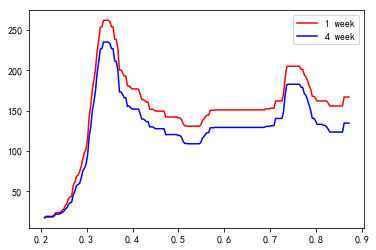

In [246]:
plt.plot(predict_df.loc[predict_df.weekday==0,'timeindex'],predict_df.loc[predict_df.weekday==0,'predict'],color='r',label='1 week')
plt.plot(predict_df.loc[predict_df.weekday==0.5,'timeindex'],predict_df.loc[predict_df.weekday==0.5,'predict'],color='b',label='4 week')
plt.legend()

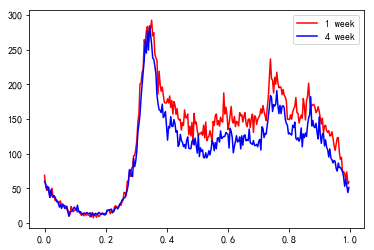

In [253]:
plt.plot(train_data.loc[train_data.weekday==0,'timeindex'],train_data.loc[train_data.weekday==0,'number']*4,color='r',label='1 week')
plt.plot(train_data.loc[train_data.weekday==0.5,'timeindex'],train_data.loc[train_data.weekday==0.5,'number']*4,color='b',label='4 week')
plt.legend()

In [91]:
LOCAL_DATA_PATH='train'
if __name__ == "__main__":
   
    # copy data from obs to local
#     mox.file.copy_parallel(OBS_DATA_PATH, LOCAL_DATA_PATH)
#     read and preprocess data
    local_data = get_data(LOCAL_DATA_PATH)
    # train model
    y_predict=train_model()
    # create config.json
#     create_config()
    # upload model to obs
#     mox.file.copy(LOCAL_MODEL_PATH, OBS_MODEL_PATH)
#     mox.file.copy(LOCAL_CONFIG_PATH, OBS_CONFIG_PATH)
    print("Model training has been completed!")

mean before: (29036, 3)
X_train shape is: (1814, 2)
X_test shape is: (202, 2)
MSE: 87.4997
Model training has been completed!
